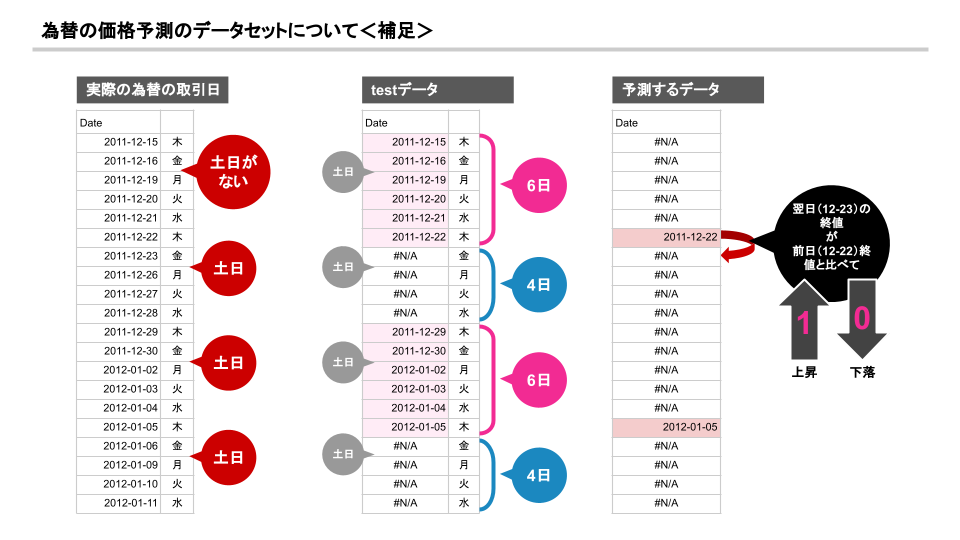

## 2. データを読み込もう

In [1]:
# 必要なライブラリのインポート
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt

#図をアウトプット行に出力するため。
%matplotlib inline

#警告を表示させない設定
import warnings
warnings.simplefilter('ignore')

#各種テクニカル分析用
import talib as ta

#日付データを扱う
import datetime

#標準化するため
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

In [2]:
#それぞれのデータの読み込み。（indexにDateを使用、parse_dates:インデックスの列をdatetime型にする）
df_train = pd.read_csv("train_finance.csv",index_col="Date",parse_dates=True)
df_test = pd.read_csv("test_finance.csv",index_col="Date",parse_dates=True)
df_submit = pd.read_csv("submit_finance.csv")
#trainデータとtestデータを結合する。
df = pd.concat([df_train, df_test], ignore_index=False, sort=False)

## 3. データの概要を確認しよう

In [3]:
#学習するデータの中身を確認する。
df_train.head(3)

,High,Low,Open,Close
Date,,,,
2003-12-01,111.370639,110.482062,111.314347,110.676377
2003-12-02,112.008532,110.500532,110.639316,111.823016
2003-12-03,112.202814,111.712284,111.832477,112.137524


In [4]:
df_train.shape

(2074, 4)

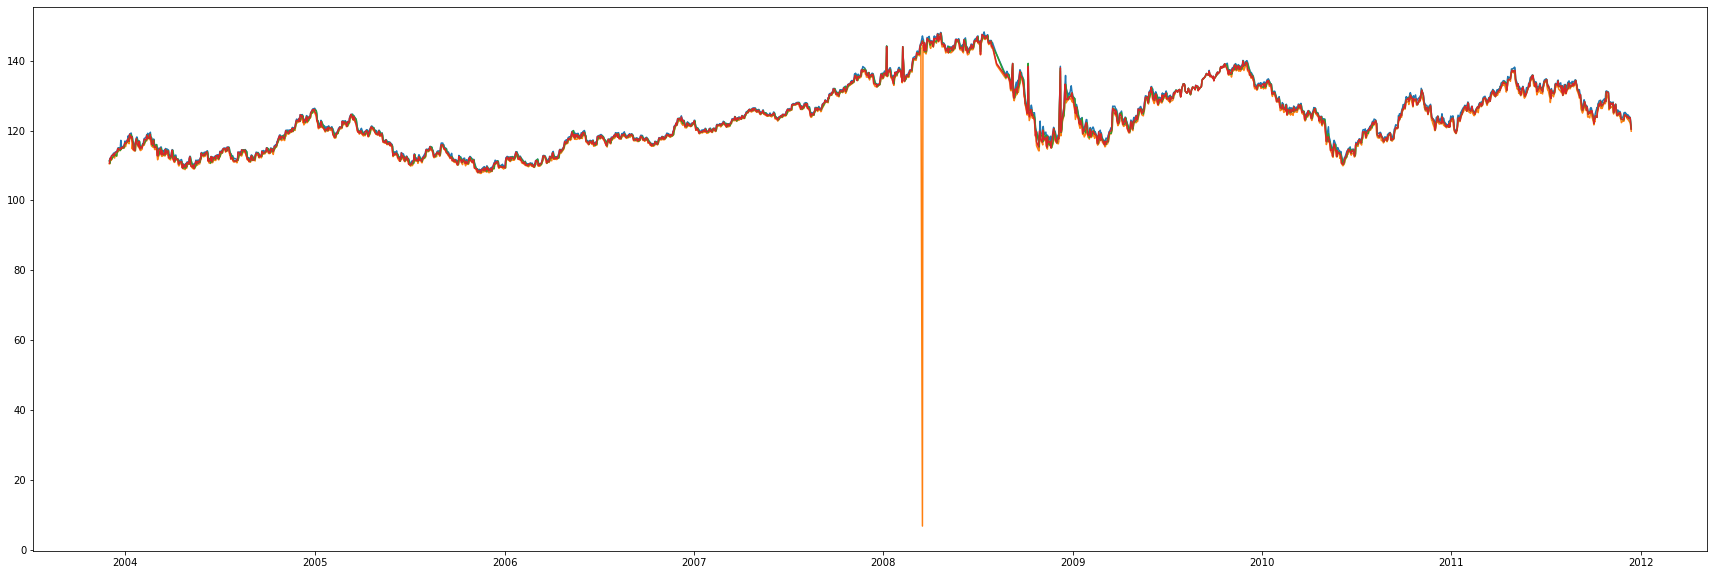

In [5]:
fig = plt.subplots(figsize=(30,10))
plt.plot(df_train)

In [6]:
#予測するデータを確認する。
df_test.head(3)

,High,Low,Open,Close
Date,,,,
2011-12-15,120.703596,119.907182,120.132990,120.139231
2011-12-16,121.027367,120.314249,120.527453,120.524311
2011-12-19,120.629617,120.111145,120.582444,120.591872


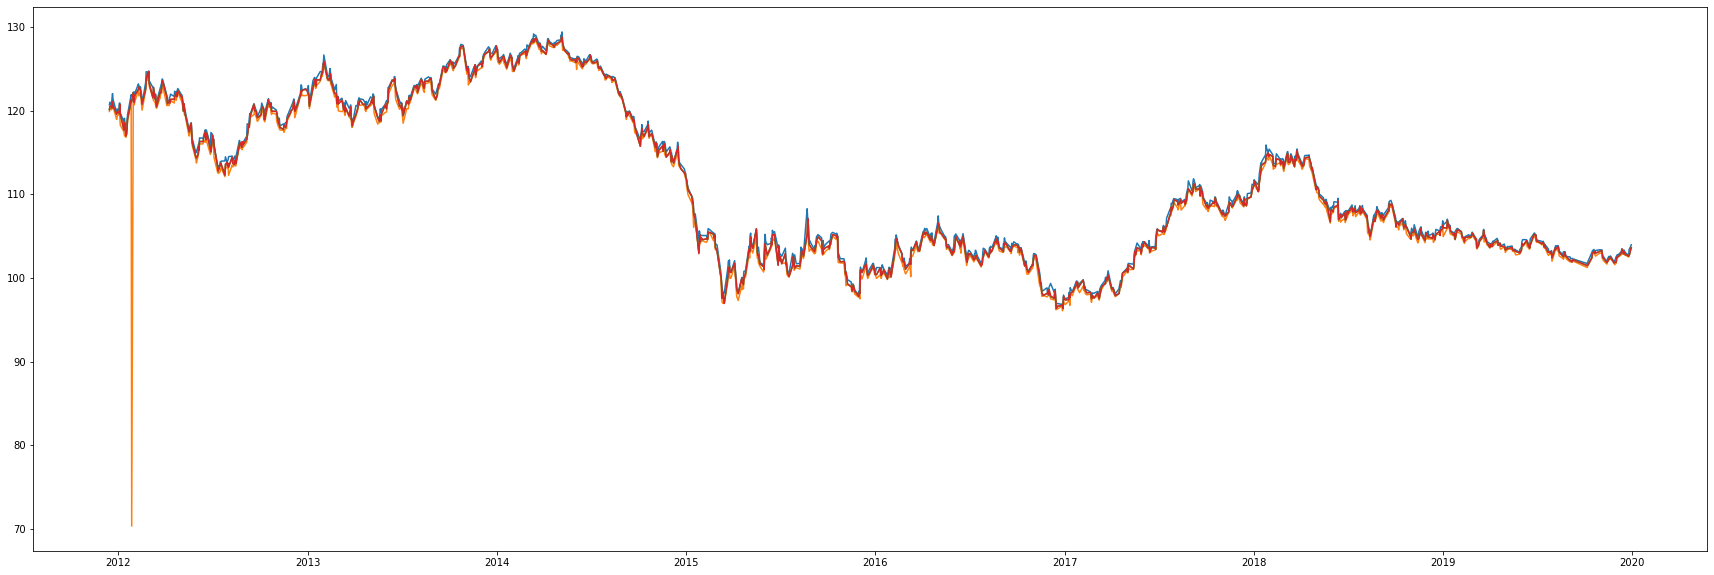

In [7]:
fig = plt.subplots(figsize=(30,10))
plt.plot(df_test)

In [8]:
#提出するデータの内容を確認する。
df_submit.head(5)

,Date
0,2011-12-22
1,2012-01-05
2,2012-01-19
3,2012-02-02
4,2012-02-16


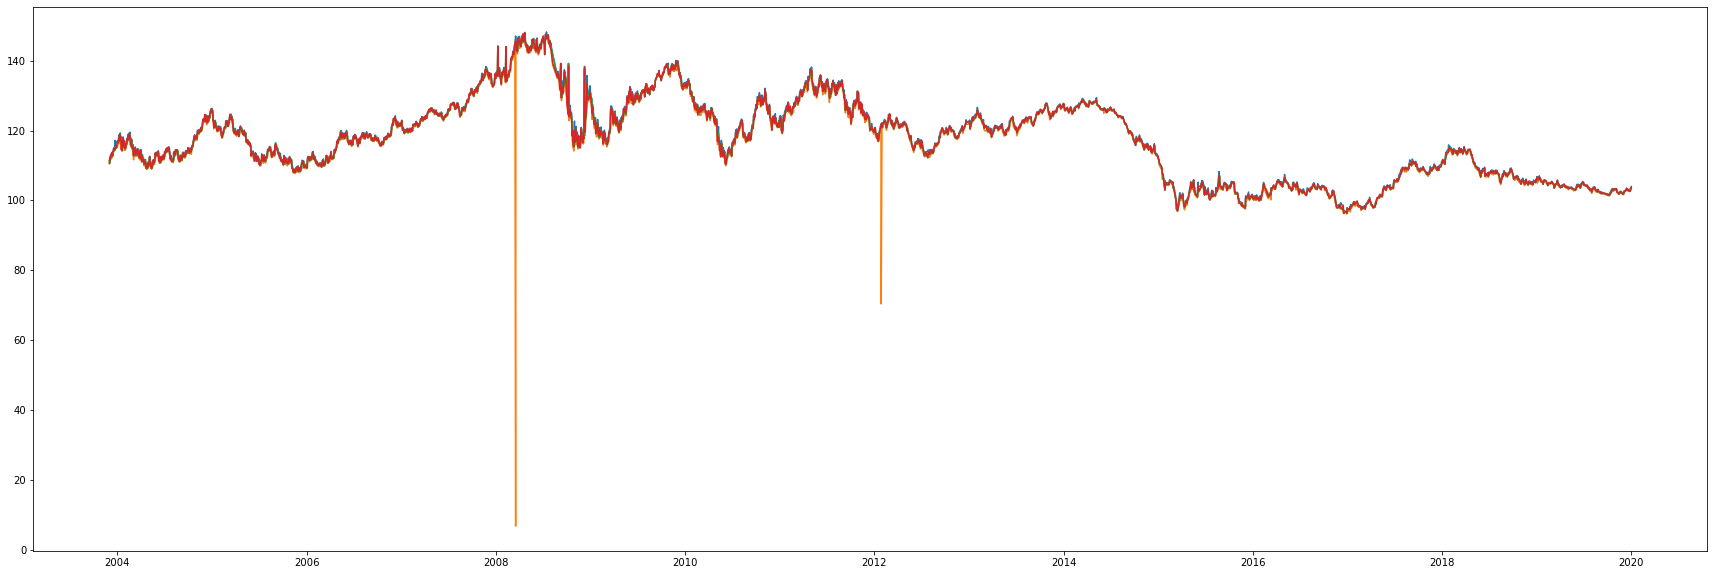

In [9]:
fig = plt.subplots(figsize=(30,10))
plt.plot(df)

#### ■ 異常値の処理（1つ前の営業日の値と同様の値に変更する）

In [10]:
# 異常値がある日を確認
df[df["Low"]<80]

,High,Low,Open,Close
Date,,,,
2008-03-17,147.103265,6.743457,145.669288,145.669288
2012-01-27,121.729745,70.352906,121.074882,121.108172


In [11]:
df["Low"].loc["2008-03-17"]=df["Low"]["2008-03-14"]
df["Low"].loc["2008-03-17"]

143.73620241880414

In [12]:
df["Low"].loc["2012-01-27"]=df["Low"]["2012-01-26"]
df["Low"].loc["2012-01-27"]

121.12720429897308

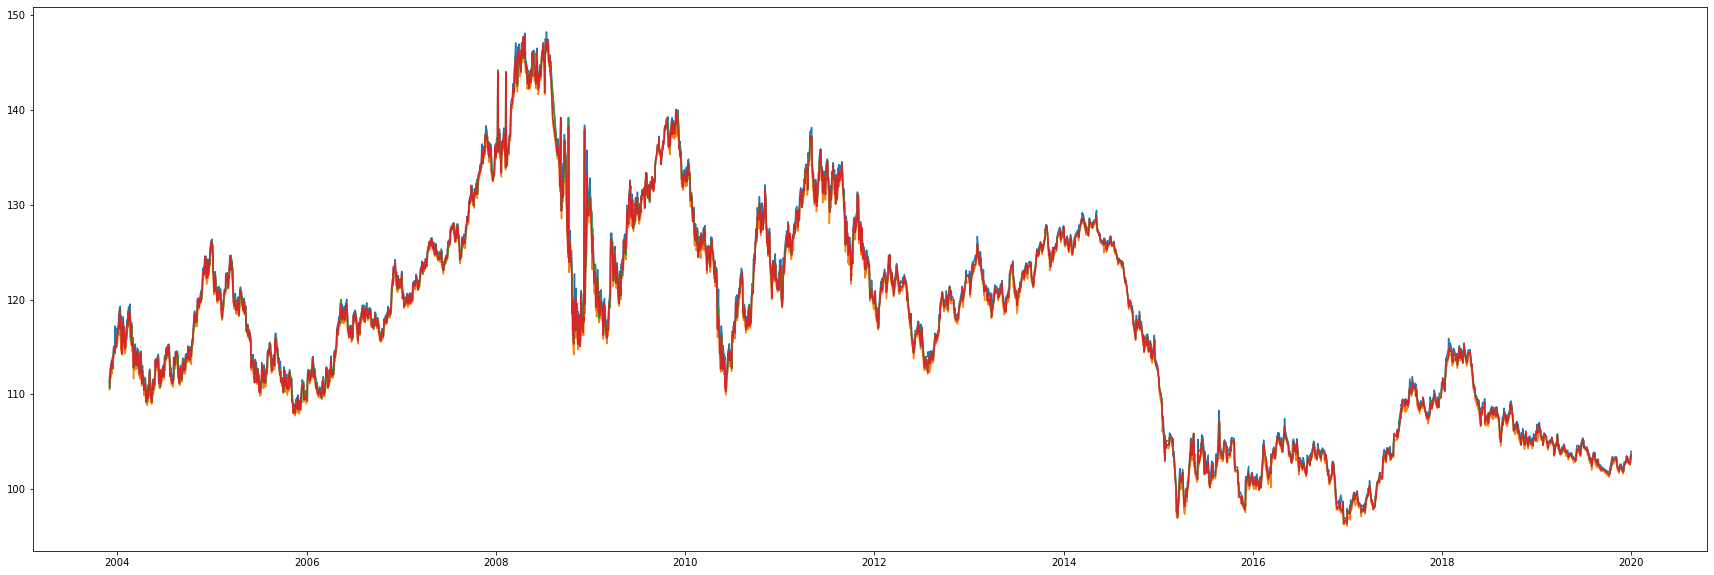

In [13]:
fig = plt.subplots(figsize=(30,10))
plt.plot(df)

In [14]:
df

,High,Low,Open,Close
Date,,,,
2003-12-01,111.370639,110.482062,111.314347,110.676377
2003-12-02,112.008532,110.500532,110.639316,111.823016
2003-12-03,112.202814,111.712284,111.832477,112.137524
2003-12-04,112.332259,111.406851,112.110343,111.748717
2003-12-05,112.766375,111.609834,111.721723,112.729259
...,...,...,...,...
2019-12-19,103.067513,102.766359,102.822331,102.822331
2019-12-26,102.720708,102.515796,102.629538,102.632956
2019-12-27,103.421288,102.674990,102.686502,102.685356


## 4. 目的変数を作成しよう

In [15]:
#翌日始値と当日終値の差のカラム（shift）を作成
df["shift"] = df["Open"].shift(-1) - df["Close"]

In [16]:
#翌日始値が当日終値よりも高ければ「1」、低ければ「0」のカラム（y）を作成する。（目的変数）
def p_day(x):
    if x < 0:
        return 0
    else:
        return 1
df['y'] = df['shift'].apply(p_day)

In [17]:
df.head(10)

,High,Low,Open,Close,shift,y
Date,,,,,,
2003-12-01,111.370639,110.482062,111.314347,110.676377,-0.037061,0
2003-12-02,112.008532,110.500532,110.639316,111.823016,0.009461,1
2003-12-03,112.202814,111.712284,111.832477,112.137524,-0.027181,0
2003-12-04,112.332259,111.406851,112.110343,111.748717,-0.026994,0
2003-12-05,112.766375,111.609834,111.721723,112.729259,-0.175559,0
2003-12-08,113.220483,112.425105,112.553700,113.035088,0.009660,1
2003-12-09,113.562415,112.831025,113.044748,113.312017,-0.008325,0
2003-12-10,113.460736,112.498941,113.303692,112.766375,0.000000,1
2003-12-11,113.173376,112.137524,112.766375,113.072392,0.027644,1


## 5. 色々な特徴量等を作成してみよう

#### ■ 陽線・陰線の日の翌日は？

In [18]:
#陽線、陰線の日を作成(陽線のみ作成)
df["yousen"] =  (df["Open"] < df["Close"]).replace([False,True],[0,1])

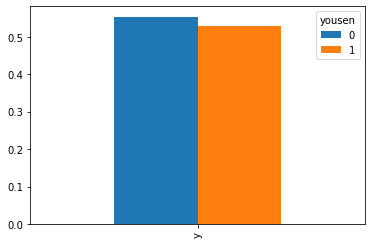

In [19]:
#pivot_table 
yousen =  pd.pivot_table(df,columns="yousen",values="y")
yousen.plot(kind="bar")

#### ■ 曜日別の信憑性を確認

In [20]:
#曜日の集計をする。
df["day_of_week"] = df.index.strftime("%A")

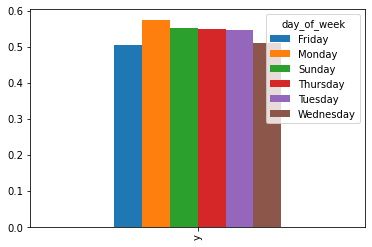

In [21]:
day_of_week = pd.pivot_table(df,columns="day_of_week",values="y")
day_of_week.plot(kind="bar")

#### ■月別の信憑性を確認

In [22]:
df["month"] = df.index.strftime("%m")

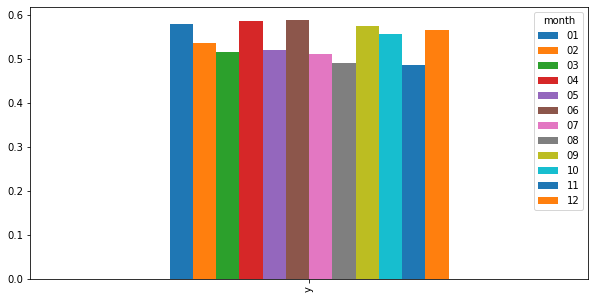

In [23]:
month_test = pd.pivot_table(df,columns=("month"),values="y")
month_test.plot(kind="bar",figsize=(10, 5))

#### ■同月で同曜日の状況確認

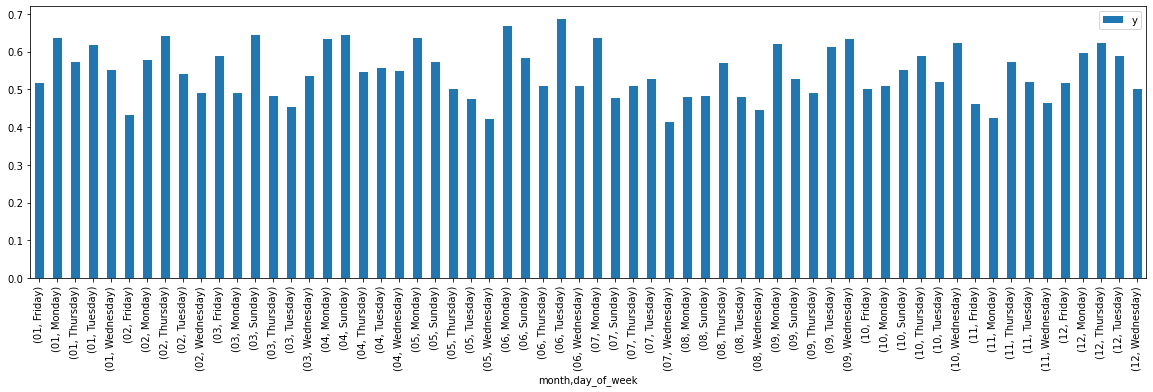

In [24]:
month_dayoweek = pd.pivot_table(df,index=("month","day_of_week"),values="y")
month_dayoweek.plot(kind="bar",figsize=(20, 5))

In [25]:
df["week"] = df.index.strftime("%w")

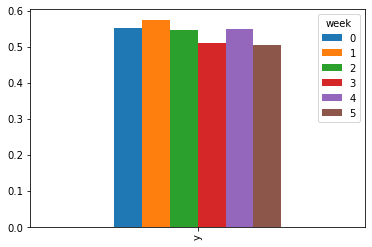

In [26]:
week_test = pd.pivot_table(df,columns="week",values="y")
week_test.plot(kind="bar")

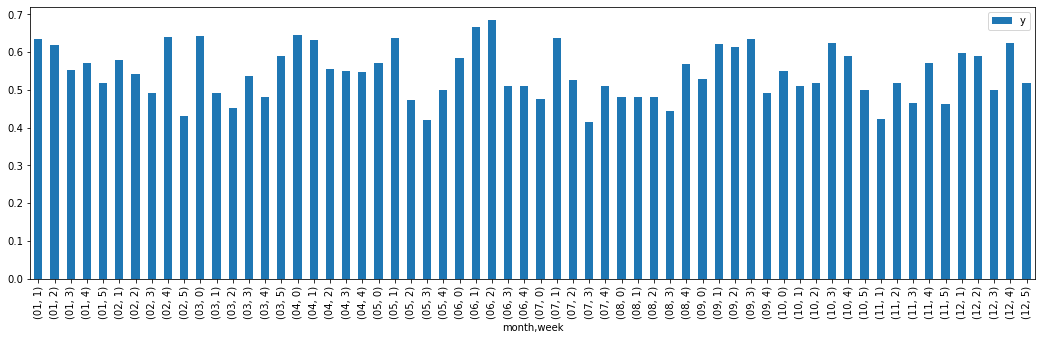

In [27]:
month_week = pd.pivot_table(df,index=("month","week"),values="y")
month_week.plot(kind="bar",figsize=(18, 5))

In [28]:
day_of_week = pd.get_dummies(df['day_of_week'])
df = pd.concat([df, day_of_week], ignore_index=False, sort=False,axis=1)

In [29]:
month = pd.get_dummies(df['month'])
df = pd.concat([df, month], ignore_index=False, sort=False,axis=1)

In [30]:
week = pd.get_dummies(df['week'])
df = pd.concat([df, week], ignore_index=False, sort=False,axis=1)

In [31]:
df.head(3)

,High,Low,Open,Close,shift,y,yousen,day_of_week,month,week,...,09,10,11,12,0,1,2,3,4,5
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-01,111.370639,110.482062,111.314347,110.676377,-0.037061,0,0,Monday,12,1,...,0,0,0,1,0,1,0,0,0,0
2003-12-02,112.008532,110.500532,110.639316,111.823016,0.009461,1,1,Tuesday,12,2,...,0,0,0,1,0,0,1,0,0,0
2003-12-03,112.202814,111.712284,111.832477,112.137524,-0.027181,0,1,Wednesday,12,3,...,0,0,0,1,0,0,0,1,0,0


### ■移動平均線の活用

In [32]:
#移動平均線作成
df['sma5'] = df['Close'].rolling(window=5).mean()
df['sma25'] = df['Close'].rolling(window=25).mean()
df['sma75'] = df['Close'].rolling(window=75).mean()

In [33]:
df.head(3)

,High,Low,Open,Close,shift,y,yousen,day_of_week,month,week,...,12,0,1,2,3,4,5,sma5,sma25,sma75
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-01,111.370639,110.482062,111.314347,110.676377,-0.037061,0,0,Monday,12,1,...,1,0,1,0,0,0,0,NaN,NaN,NaN
2003-12-02,112.008532,110.500532,110.639316,111.823016,0.009461,1,1,Tuesday,12,2,...,1,0,0,1,0,0,0,NaN,NaN,NaN
2003-12-03,112.202814,111.712284,111.832477,112.137524,-0.027181,0,1,Wednesday,12,3,...,1,0,0,0,1,0,0,NaN,NaN,NaN


#### ■ゴールデンクロスの真実確認

In [34]:
# golden Cross, sma5がsma25を上抜いたとき
df['GC'] = 0
for i in range(len(df)-1):
    if ((df['sma5'][i] - df['sma25'][i]) > 0) & ((df['sma5'][i-1] - df['sma25'][i-1]) < 0):
        df.iloc[i, len(df.columns)-1] = 1
    else:
        df.iloc[i,len(df.columns)-1] = 0

In [35]:
(df['GC'] == 1).value_counts()

False    3227
True       93
Name: GC, dtype: int64

#### ■ デッドクロスの真実確認

In [36]:
# Dead Cross, sma5がsma25を下抜いたとき
df['DC'] = 0
for i in range(len(df)-1):
    if ((df['sma5'][i] - df['sma25'][i]) < 0) & ((df['sma5'][i-1] - df['sma25'][i-1]) > 0):
        df.iloc[i, len(df.columns)-1] = 1
    else:
        df.iloc[i,len(df.columns)-1] = 0

In [37]:
(df['DC'] == 1).value_counts()

False    3227
True       93
Name: DC, dtype: int64

#### ■ RSIの真実確認
##### 基本的な使い方・・・30以下は売られすぎ、70以上は買われすぎと判断。
##### 今回実装したものは、RSI3日とRSI25日がクロスした瞬間をトレンド転換と判断し、利用する。

In [38]:
#RSiデータフレーム作成
df["RSI"] = ta.RSI(df["Close"], timeperiod=3)
df["RSI"]=df["RSI"].fillna(method="bfill").astype(int)
#RSiデータフレーム作成
df["RSI25"] = ta.RSI(df["Close"], timeperiod=25)
df["RSI25"]=df["RSI25"].fillna(method="bfill").astype(int)

In [39]:
# golden Cross, RSI5がRSI25を上抜いたとき
df['RSI_GC'] = 0
for i in range(len(df)-1):
    if ((df['RSI'][i] - df['RSI25'][i]) > 0) & ((df['RSI'][i-1] - df['RSI25'][i-1]) < 0):
        df.iloc[i, len(df.columns)-1] = 1
    else:
        df.iloc[i,len(df.columns)-1] = 0

In [40]:
(df['RSI_GC'] == 1).value_counts()

False    2885
True      435
Name: RSI_GC, dtype: int64

In [41]:
df['RSI_DC'] = 0
# dead Cross RSI5がRSI25を下抜けたとき
for i in range(len(df)-1):
    if ((df['RSI'][i] - df['RSI25'][i]) < 0) & ((df['RSI'][i-1] - df['RSI25'][i-1]) > 0):
        df.iloc[i, len(df.columns)-1] = 1
    else:
        df.iloc[i,len(df.columns)-1] = 0

In [42]:
(df['RSI_DC'] == 1).value_counts()

False    2886
True      434
Name: RSI_DC, dtype: int64

#### ■ MACDの真実確認
#### macdsignal線と12日移動平均線がクロスした瞬間を特徴量とする。

In [43]:
#MACD
df["macd"],df["macdsignal"],df["macdhist"] = ta.MACD(df["Close"], fastperiod=12, slowperiod=26, signalperiod=9)

In [44]:
# golden Cross　移動平均12日線がmacdsignal線を上抜けたとき
df['macd_GC'] = 0

for i in range(len(df)-1):
    if ((df['macd'][i] - df['macdsignal'][i]) > 0) & ((df['macd'][i-1] - df['macdsignal'][i-1]) < 0):
        df.iloc[i, len(df.columns)-1] = 1
    else:
        df.iloc[i,len(df.columns)-1] = 0

In [45]:
(df["macd_GC"] == 1).value_counts()

False    3177
True      143
Name: macd_GC, dtype: int64

In [46]:
df['macd_DC'] = 0
# dead Cross　移動平均12日線がmacdsignal線を下抜けたとき
for i in range(len(df)-1):
    if ((df['macd'][i] - df['macdsignal'][i]) < 0) & ((df['macd'][i-1] - df['macdsignal'][i-1]) > 0):
        df.iloc[i, len(df.columns)-1] = 1
    else:
        df.iloc[i,len(df.columns)-1] = 0

In [47]:
(df["macd_DC"] == 1).value_counts()

False    3178
True      142
Name: macd_DC, dtype: int64

#### ■ ボリンジャーバンドの真実確認
##### 3σ以上と−3σ以下で終わった場合を特徴量として抽出する。
##### 2σ（−2σ）を上抜け、下抜けた場合の特徴量を抽出する。

In [48]:
#ボリンジャーバンド
df["upper1"],df["middle1"],df["lower1"] = ta.BBANDS(df["Close"], timeperiod=25, nbdevup=1, nbdevdn=1, matype=0)
df["upper2"],df["middle2"],df["lower2"] = ta.BBANDS(df["Close"], timeperiod=25, nbdevup=2, nbdevdn=2, matype=0)
df["upper3"],df["middle3"],df["lower3"] = ta.BBANDS(df["Close"], timeperiod=25, nbdevup=3, nbdevdn=3, matype=0)

In [49]:
#+3sigama以上で終わった場合(特徴量として少なすぎる)
df["3sigma"] =  (df["Close"] > df["upper3"]).replace([False,True],[0,1])
#-3sigama以下で終わった場合（特徴量として少なすぎる）
df["-3sigma"] =  (df["Close"] < df["lower3"]).replace([False,True],[0,1])

In [50]:
(df["3sigma"] == 1).value_counts()

False    3307
True       13
Name: 3sigma, dtype: int64

In [51]:
(df["-3sigma"] == 1).value_counts()

False    3310
True       10
Name: -3sigma, dtype: int64

In [52]:
#　終値が2σを上抜けた場合
df['2sigma'] = 0
# dead Cross
for i in range(len(df)-1):
    if ((df['Close'][i] - df['upper2'][i]) < 0) & ((df["Close"][i-1] - df['upper2'][i-1]) > 0):
        df.iloc[i, len(df.columns)-1] = 1
    else:
        df.iloc[i,len(df.columns)-1] = 0

In [53]:
(df["2sigma"] == 1).value_counts()

False    3226
True       94
Name: 2sigma, dtype: int64

In [54]:
#　終値が-2σを下抜けた場合
df['-2sigma'] = 0
# dead Cross
for i in range(len(df)-1):
    if ((df['Close'][i] - df['lower2'][i]) < 0) & ((df["Close"][i-1] - df['lower2'][i-1]) > 0):
        df.iloc[i, len(df.columns)-1] = 1
    else:
        df.iloc[i,len(df.columns)-1] = 0

In [55]:
(df["-2sigma"] == 1).value_counts()

False    3231
True       89
Name: -2sigma, dtype: int64

#### ■ DMIの真実確認

In [56]:
from talib import PLUS_DI,MINUS_DI,ADX

In [57]:
#ADX=トレンド、+DI=上昇、-DI=下落
df["+DI"]=PLUS_DI(df["High"],df["Low"],df["Close"],timeperiod=14)
df["-DI"]=MINUS_DI(df["High"],df["Low"],df["Close"],timeperiod=14)
df["ADX"]=ADX(df["High"],df["Low"],df["Close"],timeperiod=14)

In [58]:
#ADXが30以上、＋DIが-DI以上の場合にはフラグ
df["ADX_up_trend"] =  (df["ADX"] > 40)&(df["+DI"]>df["-DI"]).replace([False,True],[0,1])
#ADXが30以上、＋DIが-DI以下の場合にはフラグ
df["ADX_down_trend"] =  (df["ADX"] > 40)&(df["+DI"]<df["-DI"]).replace([False,True],[0,1])

In [59]:
(df["ADX_up_trend"] == 1).value_counts()

False    3171
True      149
Name: ADX_up_trend, dtype: int64

In [60]:
(df["ADX_down_trend"] == 1).value_counts()

False    3226
True       94
Name: ADX_down_trend, dtype: int64

#### ■その他やりたいこと
##### タートルスープ戦術、聖杯、鞭打ち、ストキャス、一目均衡、テクニカル同士の組み合わせ等

#### ■　連続して上がった場合、連続して下がった場合

In [61]:
#連続するデータの作成
def count_continuous_values(df, column_name):
    y = df[column_name]
    df[column_name+ "_continue"] = y.groupby((y != y.shift()).cumsum()).cumcount() + 1
    return df

count_continuous_values(df,"y")

,High,Low,Open,Close,shift,y,yousen,day_of_week,month,week,...,3sigma,-3sigma,2sigma,-2sigma,+DI,-DI,ADX,ADX_up_trend,ADX_down_trend,y_continue
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-01,111.370639,110.482062,111.314347,110.676377,-0.037061,0,0,Monday,12,1,...,0,0,0,0,NaN,NaN,NaN,False,False,1
2003-12-02,112.008532,110.500532,110.639316,111.823016,0.009461,1,1,Tuesday,12,2,...,0,0,0,0,NaN,NaN,NaN,False,False,1
2003-12-03,112.202814,111.712284,111.832477,112.137524,-0.027181,0,1,Wednesday,12,3,...,0,0,0,0,NaN,NaN,NaN,False,False,1
2003-12-04,112.332259,111.406851,112.110343,111.748717,-0.026994,0,0,Thursday,12,4,...,0,0,0,0,NaN,NaN,NaN,False,False,2
2003-12-05,112.766375,111.609834,111.721723,112.729259,-0.175559,0,1,Friday,12,5,...,0,0,0,0,NaN,NaN,NaN,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-19,103.067513,102.766359,102.822331,102.822331,-0.192794,0,0,Thursday,12,4,...,0,0,0,0,24.054532,17.135190,14.591075,False,False,2
2019-12-26,102.720708,102.515796,102.629538,102.632956,0.053546,1,1,Thursday,12,4,...,0,0,0,0,22.998316,19.971953,14.051921,False,False,1
2019-12-27,103.421288,102.674990,102.686502,102.685356,0.744026,1,0,Friday,12,5,...,0,0,0,0,30.140270,17.806506,14.885631,False,False,2


In [62]:
#連続データを2回連続を0、3回から5回を1、それ以上を2に分ける。
def y_continue(x):
    if x <= 2:
        return 0
    elif 2 < x | x <= 5:
        return 1
    else:
        return 2
df['y_continue'] = df['y_continue'].apply(y_continue)

#### ■欠損が生じた行を削除する。（trainデータの初めの75行分）

In [63]:
df = df.dropna(how='any')

## 6. モデリングをし、汎化性能（モデルの性能）を確認してみよう

#### ■trainデータとtestデータを元に戻す。

In [64]:
df_train = df.loc["2003-12-01":"2011-12-14"]
df_test = df.loc["2011-12-15":"2019-12-31"]

## ■作成した特徴量（テクニカル）をグラフ化してみる（学習させるtrainデータのみ）

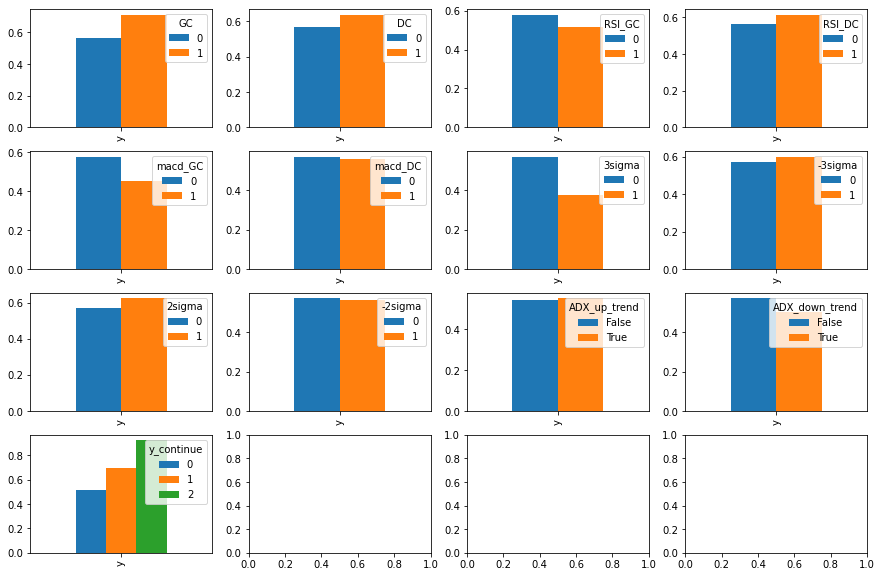

In [65]:
#移動平均線のゴールデンクロス
fig,axes = plt.subplots(nrows=4,ncols=4,figsize=(15,10))
GC =  pd.pivot_table(df_train,columns="GC",values="y")
GC.plot(kind="bar",ax=axes[0,0],legend=True)
#移動平均線のデッドクロス
DC =  pd.pivot_table(df_train,columns="DC",values="y")
DC.plot(kind="bar",ax=axes[0,1],legend=True)
#RSIのゴールデンクロス
RSI_GC =  pd.pivot_table(df_train,columns="RSI_GC",values="y")
RSI_GC.plot(kind="bar",ax=axes[0,2],legend=True)
#RSIのデッドクロス
RSI_DC =  pd.pivot_table(df_train,columns="RSI_DC",values="y")
RSI_DC.plot(kind="bar",ax=axes[0,3],legend=True)
#macdのゴールデンクロス
macd_GC =  pd.pivot_table(df_train,columns="macd_GC",values="y")
macd_GC.plot(kind="bar",ax=axes[1,0],legend=True)
#macdのデッドクロス
macd_DC =  pd.pivot_table(df_train,columns="macd_DC",values="y")
macd_DC.plot(kind="bar",ax=axes[1,1],legend=True)
#ボリバン3σ以上で終わった場合
sigma3 =  pd.pivot_table(df_train,columns="3sigma",values="y")
sigma3.plot(kind="bar",ax=axes[1,2],legend=True)
#ボリバンー3σ以上で終わった場合
sigma3_ =  pd.pivot_table(df_train,columns="-3sigma",values="y")
sigma3_.plot(kind="bar",ax=axes[1,3],legend=True)
#ボリバン2シグマを上抜けた場合
sigma2 =  pd.pivot_table(df_train,columns="2sigma",values="y")
sigma2.plot(kind="bar",ax=axes[2,0],legend=True)
#ボリバンー2シグマを上抜けた場合
sigma2_ =  pd.pivot_table(df_train,columns="-2sigma",values="y")
sigma2_.plot(kind="bar",ax=axes[2,1],legend=True)
#ADX30以上、＋DIが−DI以上
ADX_up_trend =  pd.pivot_table(df,columns="ADX_up_trend",values="y")
ADX_up_trend.plot(kind="bar",ax=axes[2,2],legend=True)
#ADX30以上、＋DIが−DI以下
ADX_down_trend =  pd.pivot_table(df_train,columns="ADX_down_trend",values="y")
ADX_down_trend.plot(kind="bar",ax=axes[2,3],legend=True)
#連続データ
y_continue =  pd.pivot_table(df_train,columns="y_continue",values="y")
y_continue.plot(kind="bar",ax=axes[3,0],legend=True)

In [66]:
df.columns

Index(['High', 'Low', 'Open', 'Close', 'shift', 'y', 'yousen', 'day_of_week',
       'month', 'week', 'Friday', 'Monday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10',
       '11', '12', '0', '1', '2', '3', '4', '5', 'sma5', 'sma25', 'sma75',
       'GC', 'DC', 'RSI', 'RSI25', 'RSI_GC', 'RSI_DC', 'macd', 'macdsignal',
       'macdhist', 'macd_GC', 'macd_DC', 'upper1', 'middle1', 'lower1',
       'upper2', 'middle2', 'lower2', 'upper3', 'middle3', 'lower3', '3sigma',
       '-3sigma', '2sigma', '-2sigma', '+DI', '-DI', 'ADX', 'ADX_up_trend',
       'ADX_down_trend', 'y_continue'],
      dtype='object')

In [67]:
#学習に使用しないデータは削除し、学習データと正解データに分ける。
drop = ['shift', 'y',
        'day_of_week', 'month', 'week', 'sma5', 'sma25', 'sma75','yousen','macd', 'macdsignal', 'macdhist',
         'upper1', 'middle1', 'lower1', 'upper2', 'middle2', 'lower2',
       'upper3', 'middle3', 'lower3', '+DI', '-DI', 'RSI', 'RSI25','ADX',]
train_X = df_train.drop(columns=drop,axis=1) 
train_y = df_train['y']

In [68]:
train_X.head(3)

,High,Low,Open,Close,Friday,Monday,Sunday,Thursday,Tuesday,Wednesday,...,RSI_DC,macd_GC,macd_DC,3sigma,-3sigma,2sigma,-2sigma,ADX_up_trend,ADX_down_trend,y_continue
Date,,,,,,,,,,,,,,,,,,,,,
2004-03-12,114.275125,112.655136,114.237027,113.072392,1,0,0,0,0,0,...,1,0,0,0,0,0,0,False,False,0
2004-03-15,113.905030,112.970206,112.979855,113.516433,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,False,1
2004-03-16,114.440539,113.275937,113.488579,113.414820,0,0,0,0,1,0,...,0,0,0,0,0,0,0,False,False,1


In [69]:
#学習データを分割するライブラリをインポートする。
from sklearn.model_selection import train_test_split

In [70]:
#学習データと正解データをそれぞれ分割（7：3）する。
X_train, X_test, y_train, y_test = train_test_split(train_X,train_y,test_size=0.3,random_state=0)

## ■ロジスティック回帰を使用

In [71]:
#必要なライブラリのインポート
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=4,C=100)
lr.fit(X_train, y_train)

LogisticRegression(C=100, random_state=4)

In [72]:
#作成したモデルを使用し予測。
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

In [73]:
#必要なライブラリのインポート（評価方法はaccuracy）
from sklearn.metrics import accuracy_score

#今回作成したモデルの汎化性能を確認する。
print("train:",accuracy_score(y_train, train_pred))
print("test",accuracy_score(y_test, test_pred))

train: 0.6321428571428571
test 0.6083333333333333


#### 交差検証する

In [74]:
#n_splits=分割回数　点数は分割したデータの予測率の平均
#モデルの汎化性能を Cross Validation (交差検証)関数 で評価
from sklearn.model_selection import cross_validate, KFold
kf = KFold(n_splits=10,shuffle=True,random_state=0)
score = cross_validate(lr,train_X,train_y,cv=kf,scoring=["accuracy"],return_estimator=True)
score["test_accuracy"].mean()

0.6005

#### 特徴量重要度（傾きの重み）と切片を取得する。

In [75]:
print("coefficient = ", lr.coef_)
print("intercept = ", lr.intercept_)

coefficient =  [[ 1.15101383  1.36062675 -1.12920946 -1.38270511  0.07443889  0.0449061
   0.04218148  0.00576146 -0.03479609 -0.0276246   0.0973462  -0.01275353
  -0.00363747  0.21380887  0.01469142  0.06874771 -0.08018518 -0.11177722
   0.06016433  0.29808249 -0.49854579  0.05892542  0.04218148  0.0449061
  -0.03479609 -0.0276246   0.00576146  0.07443889  0.70840391  0.53605793
  -0.14298107  0.13096572 -0.50921888 -0.02615597  0.01556687  0.04748492
   0.08284163 -0.15525648 -0.16663042 -0.19153265  1.11398594]]
intercept =  [0.10493397]


## ■決定木を使用

In [76]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(random_state=1,max_depth=10)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, random_state=1)

In [77]:
#作成したモデルを使用し予測。
train_pred = dtc.predict(X_train)
test_pred = dtc.predict(X_test)

In [78]:
print("train:",accuracy_score(y_train, train_pred))
print("test",accuracy_score(y_test, test_pred))

train: 0.66
test 0.5716666666666667


#### 決定木で使用した特徴量の重要度を確認する

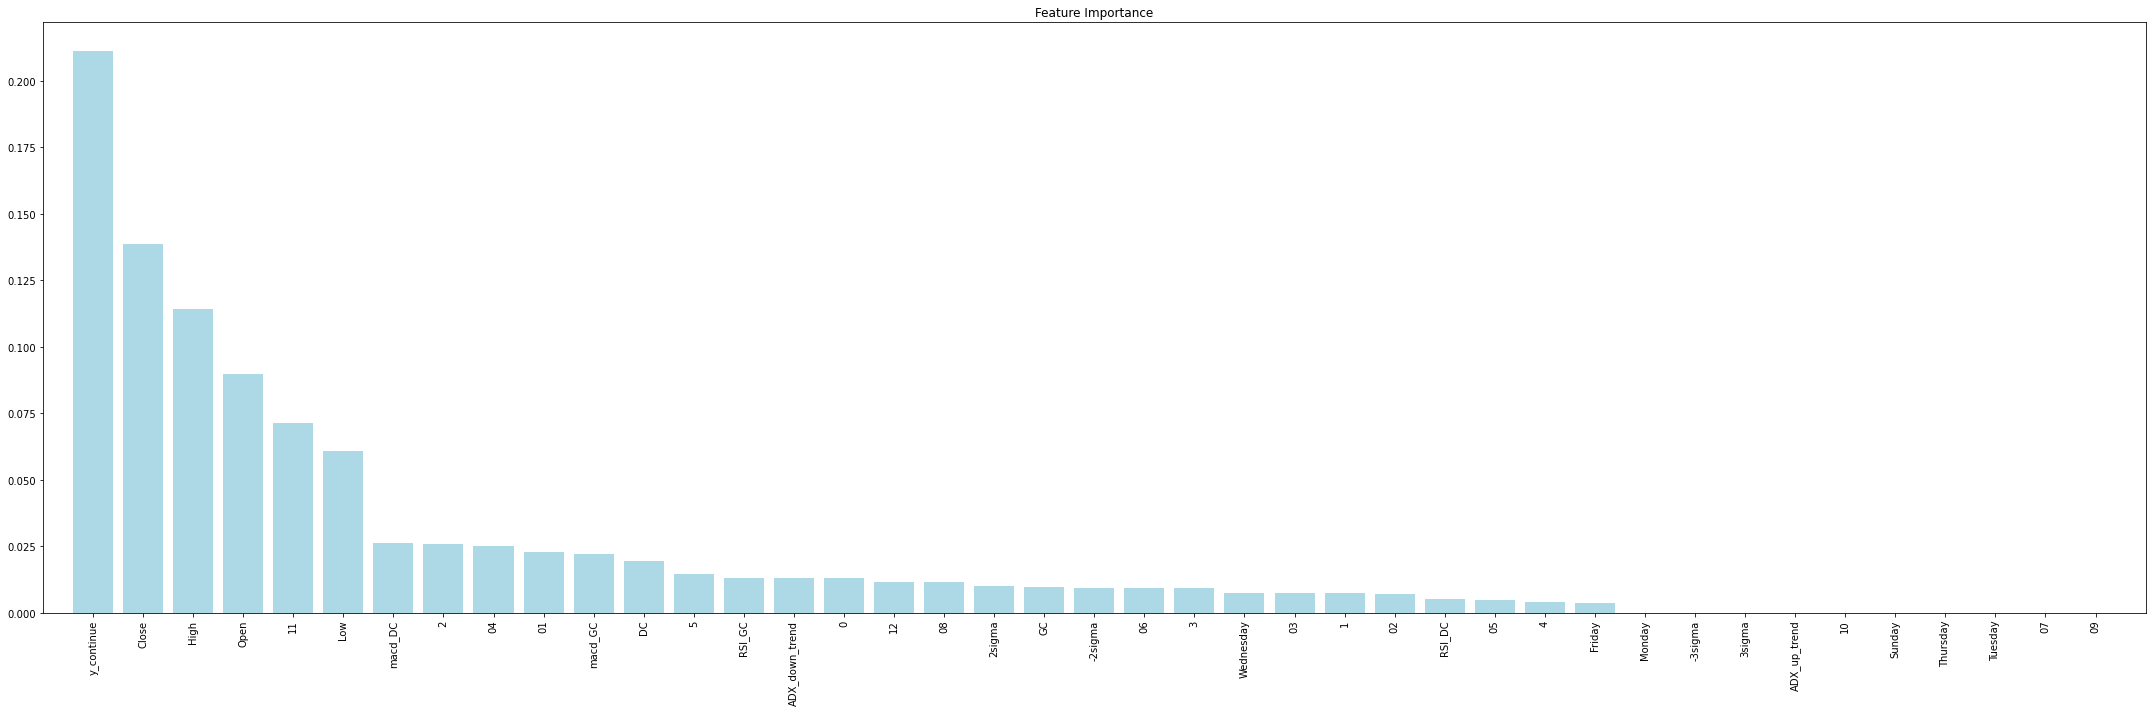

In [79]:
#特徴量の重要度
feature = dtc.feature_importances_
#特徴量の名前
label = X_train.columns[0:]
#特徴量の重要度順（降順）
indices = np.argsort(feature)[::-1]

plt.subplots(figsize=(30,10))
plt.title('Feature Importance')
plt.bar(range(len(feature)),feature[indices], color='lightblue', align='center')
plt.xticks(range(len(feature)), label[indices], rotation=90)
plt.xlim([-1, len(feature)])
plt.tight_layout()
plt.show()

## ■lightgbmを使用

In [80]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=0,max_depth=3,n_estimators=25, 
                           num_leaves=50, 
                           min_child_samples=7, 
                           learning_rate= 0.01)
lgb.fit(X_train, y_train)

LGBMClassifier(learning_rate=0.01, max_depth=3, min_child_samples=7,
               n_estimators=25, num_leaves=50, random_state=0)

In [81]:
#作成したモデルを使用し予測。
train_pred = lgb.predict(X_train)
test_pred = lgb.predict(X_test)

In [82]:
print("train:",accuracy_score(y_train, train_pred))
print("test",accuracy_score(y_test, test_pred))

train: 0.5785714285714286
test 0.5816666666666667


## 6. 予測結果を投稿しよう（ロジスティック回帰を使用）
https://kino-ds.com/finance_form

In [83]:
#作成したモデルを使用して、df_testデータ(今回予測するデータ)を予測する。
test_X = df_test.drop(columns=drop,axis=1) 
lr.predict(test_X)

array([1, 1, 0, ..., 1, 1, 1])

In [84]:
test_X

,High,Low,Open,Close,Friday,Monday,Sunday,Thursday,Tuesday,Wednesday,...,RSI_DC,macd_GC,macd_DC,3sigma,-3sigma,2sigma,-2sigma,ADX_up_trend,ADX_down_trend,y_continue
Date,,,,,,,,,,,,,,,,,,,,,
2011-12-15,120.703596,119.907182,120.132990,120.139231,0,0,0,1,0,0,...,0,0,0,0,0,0,0,False,False,0
2011-12-16,121.027367,120.314249,120.527453,120.524311,1,0,0,0,0,0,...,0,0,0,0,0,0,0,False,False,0
2011-12-19,120.629617,120.111145,120.582444,120.591872,0,1,0,0,0,0,...,0,0,0,0,0,0,0,False,False,0
2011-12-20,121.470779,120.221987,120.323633,120.322078,0,0,0,0,1,0,...,0,0,0,0,0,0,0,False,False,0
2011-12-21,122.046150,120.513328,121.063789,121.063789,0,0,0,0,0,1,...,0,0,0,0,0,0,0,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-18,103.151417,102.780065,103.151417,103.150270,0,0,0,0,0,1,...,0,0,0,0,0,0,0,False,False,0
2019-12-19,103.067513,102.766359,102.822331,102.822331,0,0,0,1,0,0,...,1,0,0,0,0,0,0,False,False,0
2019-12-26,102.720708,102.515796,102.629538,102.632956,0,0,0,1,0,0,...,0,0,0,0,0,0,0,False,False,0


In [85]:
#ndarray型から行列に変換する。
y_submit = pd.Series(lr.predict(test_X))
y_submit

0       1
1       1
2       0
3       1
4       1
       ..
1240    0
1241    1
1242    1
1243    1
1244    1
Length: 1245, dtype: int64

In [86]:
#6番目毎のデータ結果のみ取り出す。
y_submit = y_submit[5::6].reset_index(drop=True)
y_submit.shape

(207,)

In [87]:
df_submit

,Date
0,2011-12-22
1,2012-01-05
2,2012-01-19
3,2012-02-02
4,2012-02-16
...,...
202,2019-10-23
203,2019-11-07
204,2019-11-21
205,2019-12-05


In [88]:
df_submit[1] = y_submit
df_submit

,Date,1
0,2011-12-22,1
1,2012-01-05,0
2,2012-01-19,1
3,2012-02-02,0
4,2012-02-16,0
...,...,...
202,2019-10-23,1
203,2019-11-07,1
204,2019-11-21,0
205,2019-12-05,1


In [89]:
# 指定の様式（インデックスはDate、カラム名は「y」のみ）をお守りください。
df_submit = df_submit.set_index("Date") #indexにDateを指定する。
df_submit = df_submit.rename(columns={1: 'y'}) #カラム名「1」を「y」に変更する。
df_submit.to_csv('y_submit.csv') #投稿するファイルを書き出す。
df_submit #投稿する中身を確認する。

,y
Date,
2011-12-22,1
2012-01-05,0
2012-01-19,1
2012-02-02,0
2012-02-16,0
...,...
2019-10-23,1
2019-11-07,1
2019-11-21,0


# おつかれさまでした〜〜(๑>◡<๑)

In [90]:
df_submit.tail(60)

,y
Date,
2017-08-14,0
2017-08-28,1
2017-09-11,0
2017-09-25,1
2017-10-09,1
2017-10-23,1
2017-11-07,0
2017-11-22,1
2017-12-06,0
